# NLP with Disaster Tweets

## Detecting Disasters: Using BERT for NLP To Separate Forest Fires from “Fire" Shoes

#### Alexander Bricken

---

### Project Goals:
- Explore typical data science and machine learning practices by doing the following:
    - Importing data
    - Exploring data
    - Cleaning data
    - Preparing data
    - Setting up a train-test split
    - Running a machine learning model
- Apply specific NLP data preparation techniques
    - Stop word removal
    - Text cleaning using tokenization
    - Meta-feature extraction
- Apply BERT, a state-of-the-art language model for NLP

Here, we aim to compare the difference between BERT accuracy after light preprocessing and heavier preprocessing, and check these accuracies against building a CNN and training on meta-features, to find the model with the best performance.

### Table Of Contents

1. Import Libraries
2. Import Data
3. Data Exploration
4. Data Preparation
5. Calculating Meta-Features
6. Text Cleaning
7. Machine Learning
8. Preparing Kaggle Submission

---

### Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import scikitplot as skplt
import string
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert

# seaborn settings
sns.set_theme(style="whitegrid")
np.random.seed(1)
torch.manual_seed(1)

### Import Data

In [2]:
raw_test_data = pd.read_csv("../data/raw/test.csv")
raw_train_data = pd.read_csv("../data/raw/train.csv")

In [3]:
raw_train_data

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

### Data Exploration

We use PandasProfiling, a convenient library for data exploration.

In [4]:
profile = ProfileReport(raw_train_data, title="Pandas Profiling Report")

In [5]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

By using Pandas Profiling we can check through some essential features of the dataset:
- Class distribution of target variable in the train dataset. This is a 4342 (0), 3271 (1) split. This near equal separation is ok for training our model.
- Missing data. We see that the `location` and `keyword` columns contain missing data. This will be handled below.
- Cardinality. Our `location` values are particularly distinct. This is also dicussed and handled below.

### Data Preparation

`location` and `keyword` contain null values, as demonstrated by the pandas profiling report.

In [6]:
foo = [(raw_train_data[['keyword', 'location']].isnull().sum().values, raw_test_data[['keyword', 'location']].isnull().sum().values)]
out = np.concatenate(foo).ravel()

In [7]:
null_counts = pd.DataFrame({"column": ['keyword', 'location', 'keyword', 'location'],
                           "label": ['train', 'train', 'test', 'test'],
                           "count": out})

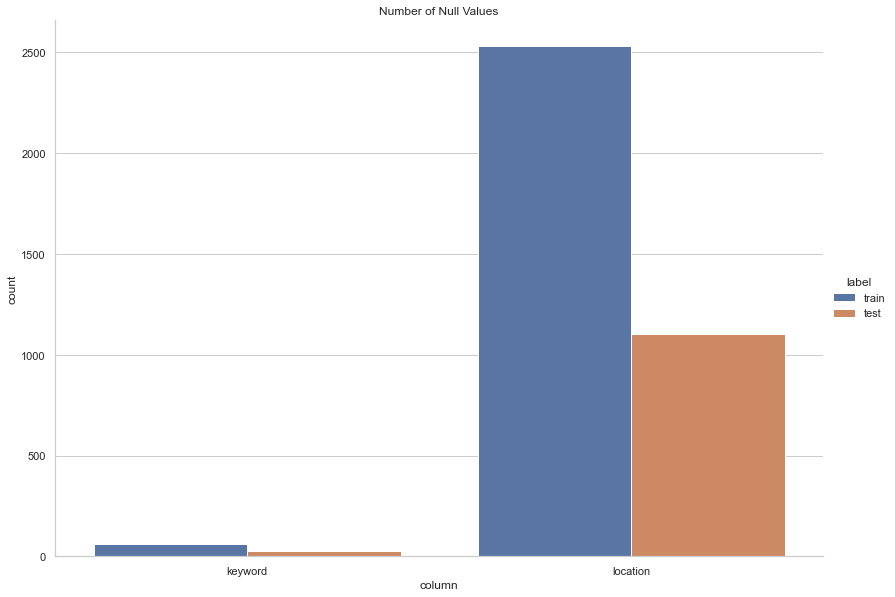

In [8]:
sns.catplot(x="column", y="count", data=null_counts, hue="label", kind="bar", height=8.27, aspect=11.7/8.27)
plt.title('Number of Null Values')
plt.show()

Locations from Twitter are user-populated and are thus too arbitrary. There are too many unique values and no standardization of input. We can remove this feature.

In [9]:
# drop location data
clean_train_data = raw_train_data.drop(columns="location")
clean_test_data = raw_test_data.drop(columns="location")

Keywords, on the other hand, are interesting to consider as a way of identifying disaster. This is because some keywords really are only used in a certain context.

What do our keywords look like? We can output wordclouds for our train and test datasets to examine this.

In [10]:
# set up stopwords (like the, and, but etc.)
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

222 unique words in the keyword column for train data.


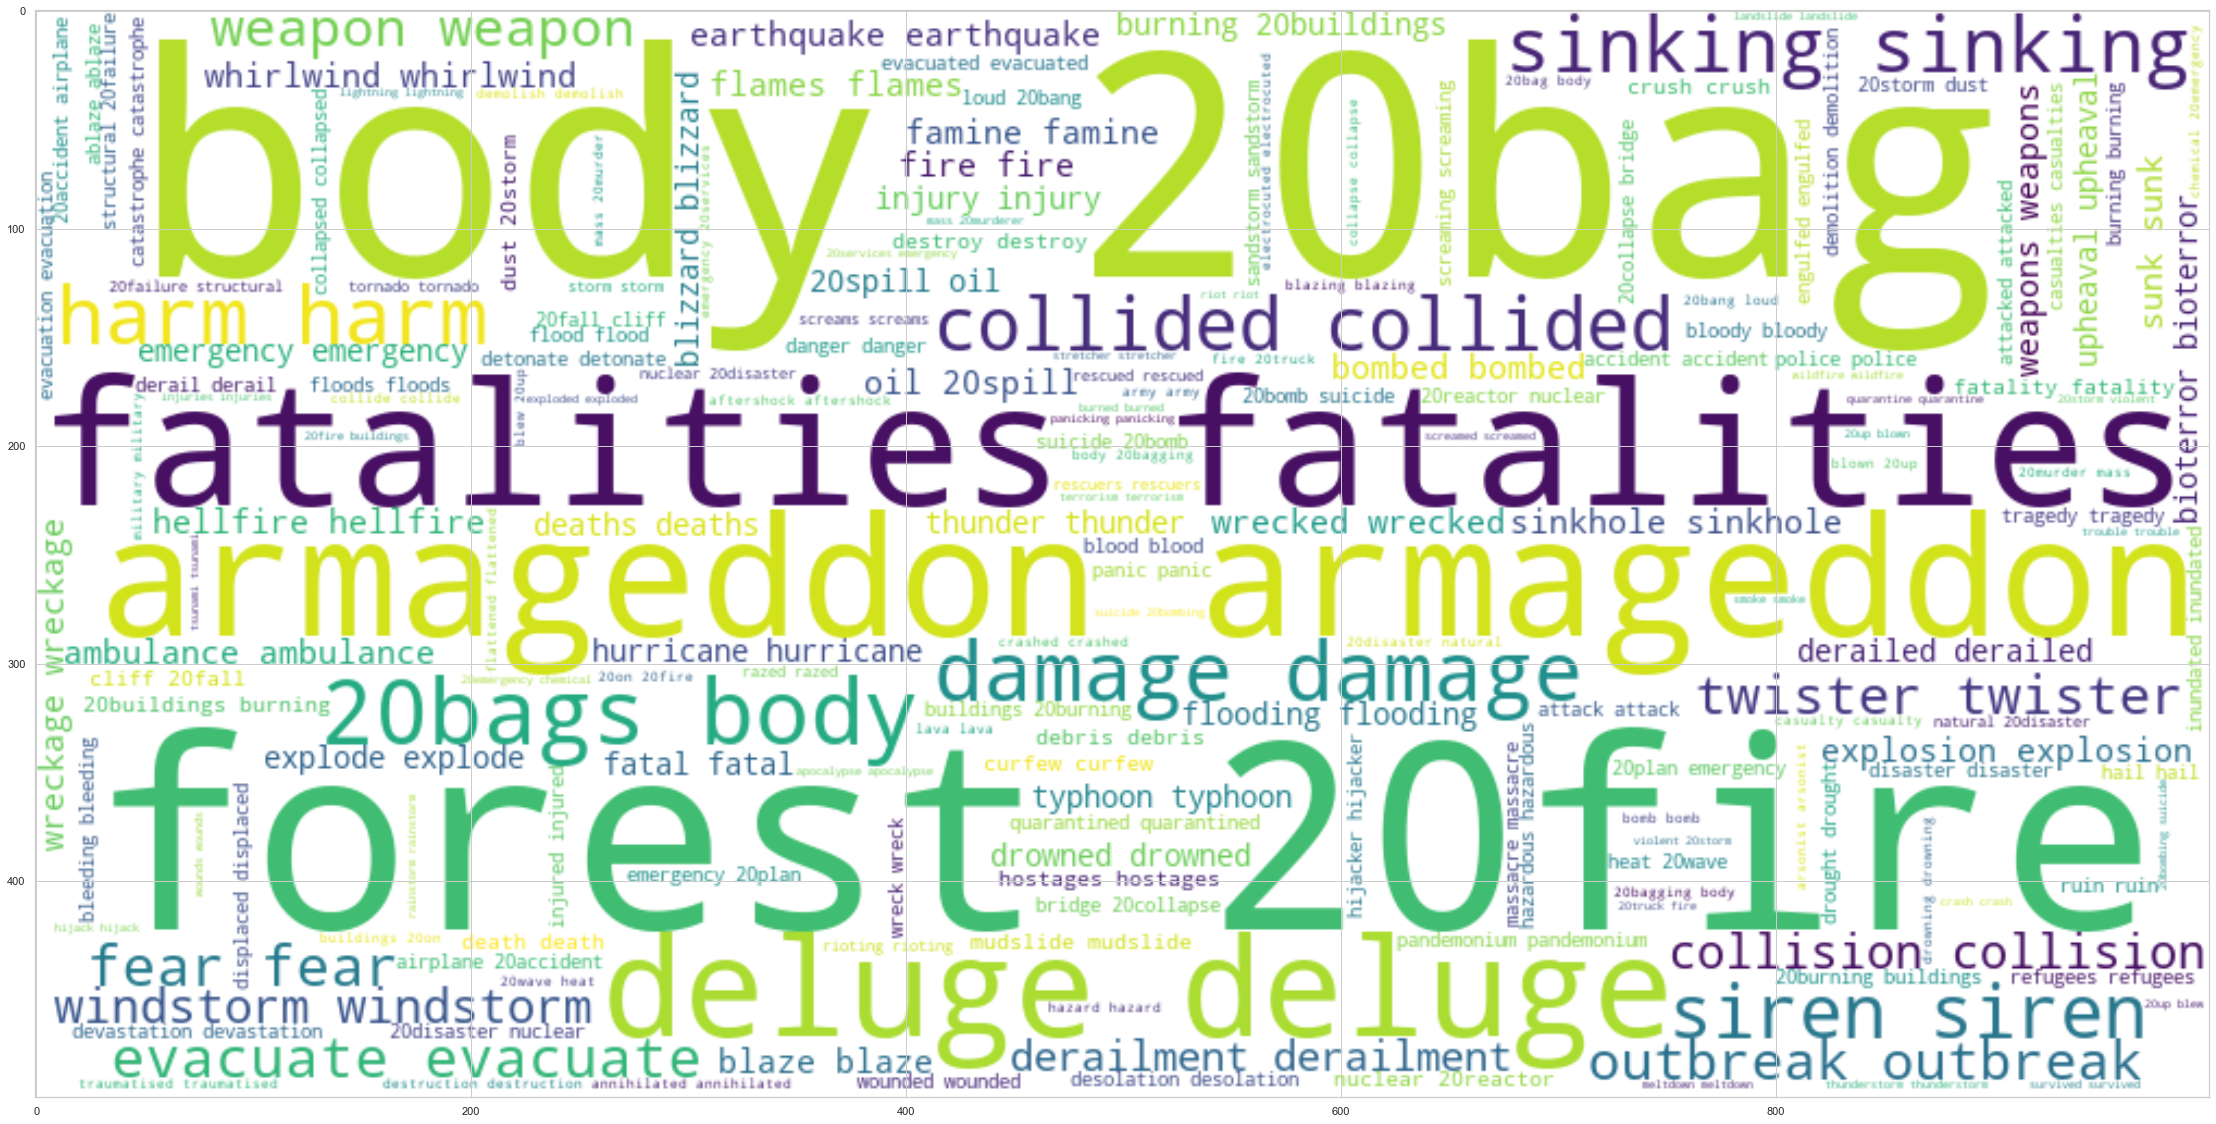

In [11]:
# for train
text = " ".join(word for word in clean_train_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for test data.


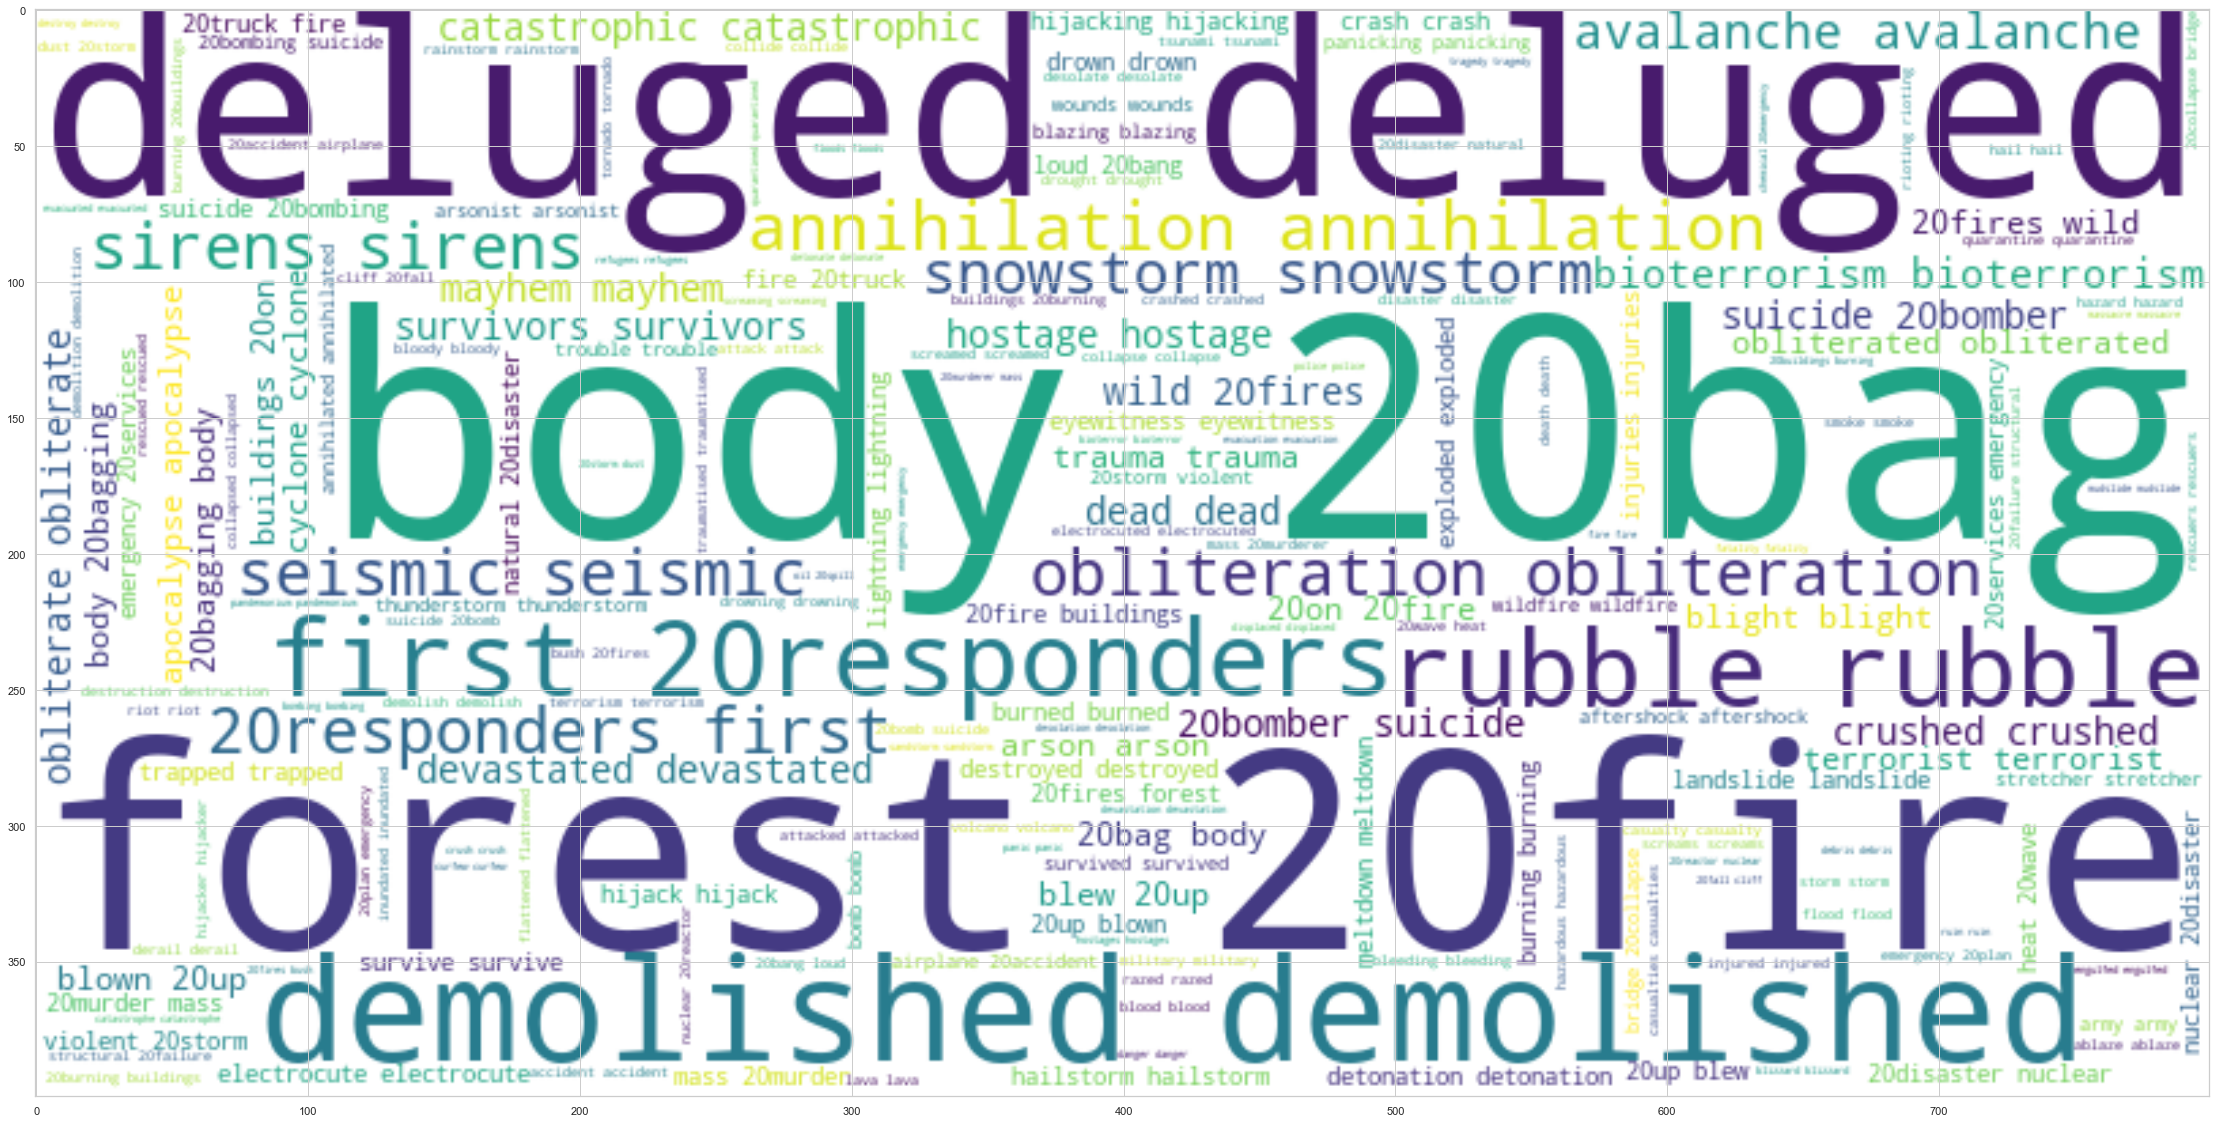

In [12]:
# for test
text = " ".join(word for word in clean_test_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for test data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We see that there is a good level of overlap between the keywords in treatment and control. Keyword is just one way of looking at the data, and if we just examine keywords there is not enough context to generate accurate predictions. Likewise, because we are implementing a BERT model which is all about the context of a word in a sentence, we don't want to do anything like add the keyword to the end of the associated Tweet to increase the weight of that word.

One clever way to leverage the keyword in our model is to convert the keyword into a sentiment score. This way, we have a value that acts as a meta-feature, without altering the important information contained in the Tweets. We do this by using NLTK library's built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alexanderbricken/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
# drop nan keyword rows
clean_train_data = clean_train_data.dropna(subset=['keyword']).reset_index(drop=True)
#clean_test_data = clean_test_data.dropna(subset=['keyword']).reset_index(drop=True)

In [16]:
# we fill none into the Nan Values, to give 0 sentiment
clean_test_data['keyword'] = clean_test_data['keyword'].fillna("None")

In [17]:
# collect keywords into arrays
train_keywords = clean_train_data['keyword']
test_keywords = clean_test_data['keyword']

# use sentiment analyser
sia = SentimentIntensityAnalyzer()
train_keyword_sia = [sia.polarity_scores(i)['compound'] for i in train_keywords]
test_keyword_sia = [sia.polarity_scores(i)['compound'] for i in test_keywords]

# update keyword column
clean_train_data['keyword'] = train_keyword_sia
clean_test_data['keyword'] = test_keyword_sia

Finally, it is worth checking for duplicates.

In [18]:
# check for duplicates using groupby
df_nondupes = clean_train_data.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes.rename(columns={'id':'# of duplicates', 'target':'sum of target var'})

# of duplicates  keyword  \
text                                                                           
like for the music video I want some real actio...                2        1   
Hellfire is surrounded by desires so be careful...                3        1   
The Prophet (peace be upon him) said 'Save your...                6        1   
To fight bioterrorism sir.                                        4        1   
He came to a land which was engulfed in tribal ...                6        1   
In #islam saving a person is equal in reward to...                2        1   
Who is bringing the tornadoes and floods. Who i...                3        1   
#Allah describes piling up #wealth thinking it ...                3        1   
wowo--=== 12000 Nigerian refugees repatriated f...                2        1   
RT NotExplained: The only known image of infamo...                2        1   
.POTUS #StrategicPatience is a strategy for #Ge...                4        1   
Mmmmmm I'm burning.... I'm burning buildings I'...                2        1   
#foodscare #offers2go #NestleIndia slips into l...                3        1   
CLEARED:incident with injury:I-495  inner loop ...                3        1   
Caution: breathing may be hazardous to your hea...                2        1   
I Pledge Allegiance To The P.O.P.E. And The Bur...                2        1   
that horrible sinking feeling when youÛªve bee...                4        1   
Hellfire! We donÛªt even want to think about i...                2        1   

                                                    sum of target var  
text                                                                   
like for the music video I want some real actio...                  2  
Hellfire is surrounded by desires so be careful...                  2  
The Prophet (peace be upon him) said 'Save your...                  2  
To fight bioterrorism sir.                                          2  
He came to a land which was engulfed in tribal ...                  2  
In #islam saving a person is equal in reward to...                  2  
Who is bringing the tornadoes and floods. Who i...                  2  
#Allah describes piling up #wealth thinking it ...                  2  
wowo--=== 12000 Nigerian refugees repatriated f...                  2  
RT NotExplained: The only known image of infamo...                  2  
.POTUS #StrategicPatience is a strategy for #Ge...                  2  
Mmmmmm I'm burning.... I'm burning buildings I'...                  2  
#foodscare #offers2go #NestleIndia slips into l...                  2  
CLEARED:incident with injury:I-495  inner loop ...                  2  
Caution: breathing may be hazardous to your hea...                  2  
I Pledge Allegiance To The P.O.P.E. And The Bur...                  2  
that horrible sinking feeling when youÛªve bee...                  2  
Hellfire! We donÛªt even want to think about i...                  2

If we iterate through these duplicates we can individually label them by hand so we keep the data. 
This is necessary because some of them are mislabeled as well as being duplicate. For example, there are three duplicates of the first row, but 2 of them have the target label 1, and one of them has target label 0. This is seen throughout the table via the difference in the the `# of duplicates` against the `sum of target var`, as seen above.

In [19]:
# take index which is the texts themselves
dupe_text_list = df_dupes.index
dupe_text_list = list(dupe_text_list) # turn into list

# manually make label list to iterate
right_labels = [0,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,0,0]

In [20]:
# drop duplicates except for one
clean_train_data = clean_train_data.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [21]:
# relabel duplicate rows
for i in range(len(dupe_text_list)):
    clean_train_data.loc[clean_train_data['text'] == dupe_text_list[i], 'target'] = right_labels[i]

### Calculating Meta-Features

We need ways to learn more about our data and separate it out into additional features. By thinking about different variables we can generate that might help us distinguish disasters from non-disasters, we can train our model on more features. This will provide more visibility for our model. The best way to think about Tweets indicating disaster are that they are likely from higher quality sources that are more serious in nature. Thus, following stricter grammatical rules, fully reporting on the situation, and sharing links (taken from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).

- `num_hashtags` count of hashtags (#) (hypothesis (H): hashtags are used by normal users rather than new agencies)
- `num_mentions` count of mentions (@) (H: more tags could be used by normal users rather than news agencies)
- `num_words` count of words (H: more words in proper reports on Twitter than normal user tweets)
- `num_stop_words` number of stop words (H: more stop words used via proper grammar from news agencies)
- `num_urls` count of urls (H: urls shared by news agencies reporting disaster more often than not)
- `avg_word_length` average character count in words (H: longer words that aren't abbreviated used by news agencies)
- `num_chars` count of characters (H: more characters used in news agency tweets to report full story)
- `num_punctuation` count of punctuations (H: more punctuation in news agency tweets following correct grammar)

We generate these new columns below.

In [22]:
### num_hashtags
clean_train_data['num_hashtags'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
clean_test_data['num_hashtags'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

### num_mentions
clean_train_data['num_mentions'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
clean_test_data['num_mentions'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

### num_words
clean_train_data['num_words'] = clean_train_data['text'].apply(lambda x: len(str(x).split()))
clean_test_data['num_words'] = clean_test_data['text'].apply(lambda x: len(str(x).split()))

### num_stop_words
clean_train_data['num_stop_words'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
clean_test_data['num_stop_words'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

### num_urls
clean_train_data['num_urls'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
clean_test_data['num_urls'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

### avg_word_length
clean_train_data['avg_word_length'] = clean_train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_test_data['avg_word_length'] = clean_test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

### num_chars
clean_train_data['num_chars'] = clean_train_data['text'].apply(lambda x: len(str(x)))
clean_test_data['num_chars'] = clean_test_data['text'].apply(lambda x: len(str(x)))

### num_punctuation
clean_train_data['num_punctuation'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
clean_test_data['num_punctuation'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

At this point, we have cleaned up the null variables from the dataset, calculated our meta-featues, and gotten rid of mislabels and duplicates. 

We can now do the following:
- Lightly clean the text data, without removing stopwords or other contextual pieces of the Tweets, and then run BERT.
- Heavily clean the text data, removing stopwords and other features that might confused the model, and then run BERT.
- Separate the meta-features from the text data and try running a CNN.

From there, we can compare the accuracy of our models appropriately.

In [23]:
# we have 2 data frames
clean_train_data

id  keyword                                               text  \
0        48      0.0  @bbcmtd Wholesale Markets ablaze http://t.co/l...   
1        49      0.0  We always try to bring the heavy. #metal #RT h...   
2        50      0.0  #AFRICANBAZE: Breaking news:Nigeria flag set a...   
3        52      0.0                 Crying out for more! Set me ablaze   
4        53      0.0  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...   
...     ...      ...                                                ...   
7442  10830      0.0   @jt_ruff23 @cameronhacker and I wrecked you both   
7443  10831      0.0  Three days off from work and they've pretty mu...   
7444  10832      0.0  #FX #forex #trading Cramer: Iger's 3 words tha...   
7445  10833      0.0  @engineshed Great atmosphere at the British Li...   
7446  10834      0.0  Cramer: Iger's 3 words that wrecked Disney's s...   

      target  num_hashtags  num_mentions  num_words  num_stop_words  num_urls  \
0          1             0             1          5               0         1   
1          0             2             0         10               3         1   
2          1             1             0          9               1         1   
3          0             0             0          7               3         0   
4          0             0             0         13               5         1   
...      ...           ...           ...        ...             ...       ...   
7442       0             0             2          7               4         0   
7443       0             0             0         20              10         0   
7444       0             3             0         12               1         1   
7445       0             0             1         13               3         1   
7446       0             0             0         11               1         1   

      avg_word_length  num_chars  num_punctuation  
0           10.200000         55                6  
1            5.800000         67                8  
2            8.222222         82                9  
3            4.000000         34                1  
4            4.923077         76                5  
...               ...        ...              ...  
7442         6.000000         48                3  
7443         4.400000        107                1  
7444         6.833333         93               11  
7445         7.076923        104                8  
7446         6.363636         80                9  

[7447 rows x 12 columns]

In [24]:
clean_test_data

id  keyword                                               text  \
0         0      0.0                 Just happened a terrible car crash   
1         2      0.0  Heard about #earthquake is different cities, s...   
2         3      0.0  there is a forest fire at spot pond, geese are...   
3         9      0.0           Apocalypse lighting. #Spokane #wildfires   
4        11      0.0      Typhoon Soudelor kills 28 in China and Taiwan   
...     ...      ...                                                ...   
3258  10861      0.0  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...   
3259  10865      0.0  Storm in RI worse than last hurricane. My city...   
3260  10868      0.0  Green Line derailment in Chicago http://t.co/U...   
3261  10874      0.0  MEG issues Hazardous Weather Outlook (HWO) htt...   
3262  10875      0.0  #CityofCalgary has activated its Municipal Eme...   

      num_hashtags  num_mentions  num_words  num_stop_words  num_urls  \
0                0             0          6               2         0   
1                1             0          9               2         0   
2                0             0         19              10         0   
3                2             0          4               0         0   
4                0             0          8               2         0   
...            ...           ...        ...             ...       ...   
3258             0             0          8               0         0   
3259             0             0         23               7         0   
3260             0             0          6               1         1   
3261             0             0          7               0         1   
3262             2             0          8               2         0   

      avg_word_length  num_chars  num_punctuation  
0            4.833333         34                0  
1            6.222222         64                3  
2            4.105263         96                2  
3            9.250000         40                3  
4            4.750000         45                0  
...               ...        ...              ...  
3258         6.000000         55                0  
3259         5.086957        139                5  
3260         8.333333         55                5  
3261         8.428571         65                7  
3262         7.625000         68                3  

[3263 rows x 11 columns]

In [25]:
# we save these as pickles
clean_train_data.to_pickle("../data/pickles/clean_train_data.pkl")
clean_test_data.to_pickle("../data/pickles/clean_test_data.pkl")